# Analysis of the Neighborhoods in San Jose, California for Starting a new Resultrant

## *Capstone Project - The Battle of Neighborhoods:*

This is the note book of the capstone project

In [1]:
!pip install geocoder
!pip install folium
!pip install matplotlib
!pip install sklearn
!pip install BeautifulSoup4

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=334b5a59a9c6e7274f77494ab032248b867fbafdb5bdd8892f3a9399c1dbf9fd
  Stored in directory: c:\users\suniva\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [2]:
!pip install lxml
!pip install geopy
!pip install html5lib

In [3]:
import pandas as pd
import numpy as np
import requests
import folium
import geocoder
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

## 1.Data

## 1.1 Get the Neighborhood Data

In [4]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_San_Jose,_California').text 
soup = BeautifulSoup(source, 'lxml')

In [5]:
table_contents=[]
mwcg = soup.find_all(class_ = "mw-category-group")
length = len(mwcg)
for i in range(1, length):
    lists = mwcg [i].find_all('a')
    for list in lists:
        cell = {}
        names = list.get('title')
        cell['Neighborhood'] = names.split(',')[0]
        table_contents.append(cell)
print(table_contents)

[{'Neighborhood': 'The Alameda'}, {'Neighborhood': 'Almaden Valley'}, {'Neighborhood': 'Alum Rock'}, {'Neighborhood': 'Alviso'}, {'Neighborhood': 'Berryessa'}, {'Neighborhood': 'Blossom Valley'}, {'Neighborhood': 'Buena Vista'}, {'Neighborhood': 'Burbank'}, {'Neighborhood': 'Cambrian'}, {'Neighborhood': 'Chinatowns in San Jose'}, {'Neighborhood': 'Communications Hill'}, {'Neighborhood': 'Coyote Valley'}, {'Neighborhood': 'Downtown Historic District (San Jose'}, {'Neighborhood': 'Downtown San Jose'}, {'Neighborhood': 'East Foothills'}, {'Neighborhood': 'East San Jose'}, {'Neighborhood': 'Edenvale'}, {'Neighborhood': 'Evergreen'}, {'Neighborhood': 'Fruitdale'}, {'Neighborhood': 'Japantown'}, {'Neighborhood': 'King & Story'}, {'Neighborhood': 'Little Portugal'}, {'Neighborhood': 'Little Saigon'}, {'Neighborhood': 'Luna Park'}, {'Neighborhood': 'Mayfair'}, {'Neighborhood': 'Meadowfair'}, {'Neighborhood': 'Midtown San Jose'}, {'Neighborhood': 'Naglee Park'}, {'Neighborhood': 'New Almaden'},

In [6]:
df=pd.DataFrame(table_contents)

In [7]:
df.head(10)

,Neighborhood
0,The Alameda
1,Almaden Valley
2,Alum Rock
3,Alviso
4,Berryessa
5,Blossom Valley
6,Buena Vista
7,Burbank
8,Cambrian
9,Chinatowns in San Jose


In [8]:
df['Neighborhood']=df['Neighborhood'].replace({'Downtown Historic District (San Jose':'Downtown Historic District',
                                             'West Valley (California)':'West Valley'})
df = df.drop([56], axis=0)

In [9]:
df.head(10)

,Neighborhood
0,The Alameda
1,Almaden Valley
2,Alum Rock
3,Alviso
4,Berryessa
5,Blossom Valley
6,Buena Vista
7,Burbank
8,Cambrian
9,Chinatowns in San Jose


## 1.2 Geographical Coordinates

In [10]:
# Initialize varialbes
lat = []
lng = []
lat_lng_coords = None

# Get postcodes from neighbourhoods table
neighbourhoods = df['Neighborhood']

# Store latitude and longitude values in lat and lng
for nh in neighbourhoods:
    g = geocoder.arcgis('{}, San Jose, US'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [11]:
df['Latitude'] = lat
df['Longitude'] = lng

In [12]:
df.head(10)

,Neighborhood,Latitude,Longitude
0,The Alameda,37.339853,-121.922102
1,Almaden Valley,37.231118,-121.894036
2,Alum Rock,37.378805,-121.819188
3,Alviso,37.425400,-121.973220
4,Berryessa,37.386340,-121.860750
5,Blossom Valley,37.239169,-121.937536
6,Buena Vista,37.319650,-121.918550
7,Burbank,37.325300,-121.929370
8,Cambrian,37.275160,-121.940299
9,Chinatowns in San Jose,37.338650,-121.885420


### 1.3 Venue Data

In [13]:
# Access Info
CLIENT_ID = '5HGH2FPRWVAV14H1N1ZIMV1S5HKHIIF20CTBPVJGMERWXN23' # your Foursquare ID
CLIENT_SECRET = 'GMEWDYANPUIUNYZHYVGC4UBD34R0US54RYF14B0VJXV104W0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: 5HGH2FPRWVAV14H1N1ZIMV1S5HKHIIF20CTBPVJGMERWXN23
CLIENT_SECRET:GMEWDYANPUIUNYZHYVGC4UBD34R0US54RYF14B0VJXV104W0


In [14]:
#Plot the map
map_sanjose = folium.Map(location=[37.339853,-121.922102],zoom_start=12)
for lat,lng,neighborhood in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sanjose)
map_sanjose

In [15]:
#Create Function
def getNearbyVenues(names, latitudes, longitudes, radius=500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)  
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)           
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']       
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']    
    return(nearby_venues)

In [16]:
#Explore all the neighborhood
sanjose_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

The Alameda
Almaden Valley
Alum Rock
Alviso
Berryessa
Blossom Valley
Buena Vista
Burbank
Cambrian
Chinatowns in San Jose
Communications Hill
Coyote Valley
Downtown Historic District
Downtown San Jose
East Foothills
East San Jose
Edenvale
Evergreen
Fruitdale
Japantown
King & Story
Little Portugal
Little Saigon
Luna Park
Mayfair
Meadowfair
Midtown San Jose
Naglee Park
New Almaden
North San Jose
North San Pedro
Northside
Palm Haven
Qmunity District
Rincon de los Esteros
Rincon South
Rose Garden
San Jose
San Pedro Square
Santa Teresa
Santana Row
Seven Trees
College Park
Shasta Hanchett Park
Silver Creek Valley
SoFA District
South San Jose
Spartan Keyes
St. Leo's
Tamien
Washington-Guadalupe
West San Carlos
West San Jose
West Valley
Willow Glen
Winchester


In [17]:
print(sanjose_venues.shape)
sanjose_venues.head()

(1226, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Alameda,37.339853,-121.922102,Central YMCA,37.337796,-121.919896,Gym
1,The Alameda,37.339853,-121.922102,Mango's Mexican Grill,37.340504,-121.921661,Mexican Restaurant
2,The Alameda,37.339853,-121.922102,Lonich Patton Ehrlich Policastri,37.339709,-121.922588,Lawyer
3,The Alameda,37.339853,-121.922102,Telesky Financial Services,37.341737,-121.923445,Financial or Legal Service
4,The Alameda,37.339853,-121.922102,La Crema,37.337841,-121.920225,Café


In [18]:
sanjose_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Almaden Valley,1,1,1,1,1,1
Alviso,8,8,8,8,8,8
Berryessa,28,28,28,28,28,28
Blossom Valley,3,3,3,3,3,3
Buena Vista,13,13,13,13,13,13
Burbank,24,24,24,24,24,24
Cambrian,8,8,8,8,8,8
Chinatowns in San Jose,24,24,24,24,24,24
College Park,13,13,13,13,13,13


In [19]:
print('There are {} uniques categories.'.format(len(sanjose_venues['Venue Category'].unique())))

There are 209 uniques categories.


In [20]:
# one hot encoding
sanjose_onehot = pd.get_dummies(sanjose_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sanjose_onehot['Neighborhood'] = sanjose_venues['Neighborhood'] 

sanjose_onehot.head()

,Accessories Store,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
sanjose_onehot.shape

(1226, 209)

In [22]:
sanjose_grouped = sanjose_onehot.groupby('Neighborhood').mean().reset_index()
sanjose_grouped

,Neighborhood,Accessories Store,American Restaurant,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Almaden Valley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,Alviso,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,Berryessa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,Blossom Valley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,Buena Vista,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5,Burbank,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.00000,0.000000
6,Cambrian,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
7,Chinatowns in San Jose,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,...,0.041667,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
8,College Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
9,Communications Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [23]:
sanjose_grouped.shape

(55, 209)

Print 5 most hot venue in each neighbour

In [24]:
num_top_venues = 5
for hood in sanjose_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sanjose_grouped[sanjose_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Almaden Valley----
               venue  freq
0         Playground   1.0
1  Accessories Store   0.0
2               Park   0.0
3        Music Venue   0.0
4         Nail Salon   0.0


----Alviso----
                venue  freq
0  Mexican Restaurant  0.25
1         Golf Course  0.12
2          Restaurant  0.12
3               River  0.12
4               Plaza  0.12


----Berryessa----
                  venue  freq
0           Pizza Place  0.11
1  Fast Food Restaurant  0.07
2                  Bank  0.07
3            Donut Shop  0.04
4        Discount Store  0.04


----Blossom Valley----
                     venue  freq
0           Baseball Field   1.0
1        Accessories Store   0.0
2              Music Store   0.0
3               Nail Salon   0.0
4  New American Restaurant   0.0


----Buena Vista----
             venue  freq
0  Motorcycle Shop  0.23
1    Grocery Store  0.08
2   Clothing Store  0.08
3   Cosmetics Shop  0.08
4         Pharmacy  0.08


----Burbank----
                 

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sanjose_grouped['Neighborhood']

for ind in np.arange(sanjose_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sanjose_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Almaden Valley,Playground,Accessories Store,Park,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop
1,Alviso,Mexican Restaurant,Golf Course,Restaurant,River,Plaza,Convenience Store,Food Truck,Accessories Store,Nightclub,Noodle House
2,Berryessa,Pizza Place,Fast Food Restaurant,Bank,Donut Shop,Discount Store,Optical Shop,Gym / Fitness Center,Chinese Restaurant,Convenience Store,Gas Station
3,Blossom Valley,Baseball Field,Accessories Store,Music Store,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Repair Shop
4,Buena Vista,Motorcycle Shop,Grocery Store,Clothing Store,Cosmetics Shop,Pharmacy,Other Repair Shop,Video Store,Fast Food Restaurant,Gym / Fitness Center,Burger Joint
5,Burbank,Grocery Store,Discount Store,Mexican Restaurant,Pizza Place,Thrift / Vintage Store,Karaoke Bar,Bar,Fried Chicken Joint,Middle Eastern Restaurant,Watch Shop
6,Cambrian,Pet Store,Hotel,Automotive Shop,Mobile Phone Shop,Bakery,Park,Market,Concert Hall,Nightclub,Noodle House
7,Chinatowns in San Jose,Sandwich Place,Mexican Restaurant,Latin American Restaurant,Bar,Seafood Restaurant,Diner,Shipping Store,Convenience Store,Grocery Store,Café
8,College Park,Mexican Restaurant,Track,Insurance Office,Convenience Store,Thrift / Vintage Store,Pharmacy,Bakery,Gym,Intersection,Liquor Store
9,Communications Hill,Park,Gym / Fitness Center,Pizza Place,Bakery,Business Service,Accessories Store,Nail Salon,New American Restaurant,Nightclub,Noodle House


## 2. Data Clustering

In [27]:
sanjose_grouped_clustering = sanjose_grouped.drop('Neighborhood', 1)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [29]:
max_range = 15 #Max range 15 (number of clusters)
from sklearn.metrics import silhouette_samples, silhouette_score
indices = []
scores = []
for sj_clusters in range(2, max_range) :    
    # Run k-means clustering
    kmeans = KMeans(n_clusters = sj_clusters, init = 'k-means++', random_state = 0).fit_predict(sanjose_grouped_clustering)   
    # Gets the score for the clustering operation performed
    score = silhouette_score(sanjose_grouped_clustering, kmeans)    
    # Appending the index and score to the respective lists
    indices.append(sj_clusters)
    scores.append(score)

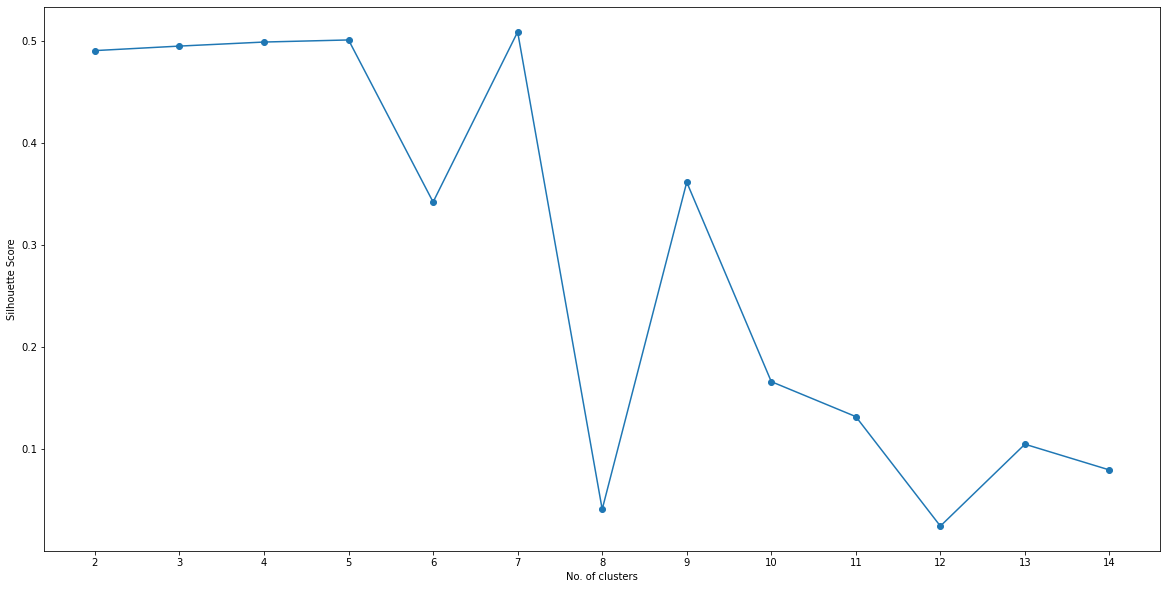

In [30]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

From the plot above, the best k is 4 since it give the largest silhouette score.

In [31]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sanjose_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [33]:
sanjose_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
sanjose_merged = sanjose_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
sanjose_merged = sanjose_merged.dropna()
sanjose_merged # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Alameda,37.339853,-121.922102,0.0,Intersection,Mexican Restaurant,Liquor Store,Café,Lawyer,Financial or Legal Service,Gym,Other Repair Shop,Outdoors & Recreation,Outdoor Sculpture
1,Almaden Valley,37.231118,-121.894036,0.0,Playground,Accessories Store,Park,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop
3,Alviso,37.425400,-121.973220,0.0,Mexican Restaurant,Golf Course,Restaurant,River,Plaza,Convenience Store,Food Truck,Accessories Store,Nightclub,Noodle House
4,Berryessa,37.386340,-121.860750,0.0,Pizza Place,Fast Food Restaurant,Bank,Donut Shop,Discount Store,Optical Shop,Gym / Fitness Center,Chinese Restaurant,Convenience Store,Gas Station
5,Blossom Valley,37.239169,-121.937536,1.0,Baseball Field,Accessories Store,Music Store,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Repair Shop
6,Buena Vista,37.319650,-121.918550,0.0,Motorcycle Shop,Grocery Store,Clothing Store,Cosmetics Shop,Pharmacy,Other Repair Shop,Video Store,Fast Food Restaurant,Gym / Fitness Center,Burger Joint
7,Burbank,37.325300,-121.929370,0.0,Grocery Store,Discount Store,Mexican Restaurant,Pizza Place,Thrift / Vintage Store,Karaoke Bar,Bar,Fried Chicken Joint,Middle Eastern Restaurant,Watch Shop
8,Cambrian,37.275160,-121.940299,0.0,Pet Store,Hotel,Automotive Shop,Mobile Phone Shop,Bakery,Park,Market,Concert Hall,Nightclub,Noodle House
9,Chinatowns in San Jose,37.338650,-121.885420,0.0,Sandwich Place,Mexican Restaurant,Latin American Restaurant,Bar,Seafood Restaurant,Diner,Shipping Store,Convenience Store,Grocery Store,Café
10,Communications Hill,37.283897,-121.848814,0.0,Park,Gym / Fitness Center,Pizza Place,Bakery,Business Service,Accessories Store,Nail Salon,New American Restaurant,Nightclub,Noodle House


In [34]:
# create map
map_clusters = folium.Map(location=[37.339853,-121.922102], zoom_start=12)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sanjose_merged['Latitude'], sanjose_merged['Longitude'], sanjose_merged['Neighborhood'], sanjose_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)       
map_clusters

## 3. Analysis of the cluster

In [35]:
lrange = [0] + [i for i in range(4, sanjose_merged.shape[1])]

In [36]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 0, sanjose_merged.columns[lrange]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Alameda,Intersection,Mexican Restaurant,Liquor Store,Café,Lawyer,Financial or Legal Service,Gym,Other Repair Shop,Outdoors & Recreation,Outdoor Sculpture
1,Almaden Valley,Playground,Accessories Store,Park,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop
3,Alviso,Mexican Restaurant,Golf Course,Restaurant,River,Plaza,Convenience Store,Food Truck,Accessories Store,Nightclub,Noodle House
4,Berryessa,Pizza Place,Fast Food Restaurant,Bank,Donut Shop,Discount Store,Optical Shop,Gym / Fitness Center,Chinese Restaurant,Convenience Store,Gas Station
6,Buena Vista,Motorcycle Shop,Grocery Store,Clothing Store,Cosmetics Shop,Pharmacy,Other Repair Shop,Video Store,Fast Food Restaurant,Gym / Fitness Center,Burger Joint
7,Burbank,Grocery Store,Discount Store,Mexican Restaurant,Pizza Place,Thrift / Vintage Store,Karaoke Bar,Bar,Fried Chicken Joint,Middle Eastern Restaurant,Watch Shop
8,Cambrian,Pet Store,Hotel,Automotive Shop,Mobile Phone Shop,Bakery,Park,Market,Concert Hall,Nightclub,Noodle House
9,Chinatowns in San Jose,Sandwich Place,Mexican Restaurant,Latin American Restaurant,Bar,Seafood Restaurant,Diner,Shipping Store,Convenience Store,Grocery Store,Café
10,Communications Hill,Park,Gym / Fitness Center,Pizza Place,Bakery,Business Service,Accessories Store,Nail Salon,New American Restaurant,Nightclub,Noodle House
11,Coyote Valley,Disc Golf,Lake,Health & Beauty Service,Smoke Shop,Accessories Store,Park,New American Restaurant,Nightclub,Noodle House,Opera House


In [37]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 1, sanjose_merged.columns[lrange]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Blossom Valley,Baseball Field,Accessories Store,Music Store,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Repair Shop


In [38]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 2, sanjose_merged.columns[lrange]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Qmunity District,Pedestrian Plaza,American Restaurant,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Repair Shop


In [39]:
sanjose_merged.loc[sanjose_merged['Cluster Labels'] == 3, sanjose_merged.columns[lrange]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Santa Teresa,Shopping Mall,Accessories Store,Park,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop


This is the end of the Notebook